# Support Vector Machine

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
features = pd.read_csv('features.csv', index_col=0, header=[0, 1, 2])
tracks = pd.read_csv('tracks.csv', index_col=0, header=[0, 1])

In [9]:
CENS = 'chroma_cens'
CQT = 'chroma_cqt'
STFT = 'chroma_stft'
MFCC = 'mfcc'
RMSE = 'rmse'
BW = 'spectral_bandwidth'
CENT = 'spectral_centroid'
CONT = 'spectral_contrast'
ROLLOFF = 'spectral_rolloff'
TON = 'tonnetz'
ZCR = 'zcr'
all_features = [CENS,CQT,STFT,MFCC,RMSE,BW,CENT,CONT,ROLLOFF,TON,ZCR]

ROCK = tracks['track', 'genre_top'] == "Rock"
ELECTRONIC = tracks['track', 'genre_top'] == "Electronic"
CLASSICAL = tracks['track', 'genre_top'] == "Classical"
HIPHOP = tracks['track', 'genre_top'] == "Hip-Hop"
FOLK = tracks['track', 'genre_top'] == "Folk"
INSTRUMENTAL = tracks['track', 'genre_top'] == "Instrumental"
OLD = tracks['track', 'genre_top'] == "Old-Time / Historic"
INTERNATIONAL = tracks['track', 'genre_top'] == "International"
EXPERIMENTAL = tracks['track', 'genre_top'] == "Experimental"
POP = tracks['track', 'genre_top'] == "Pop"
JAZZ = tracks['track', 'genre_top'] == "Jazz"
SPOKEN = tracks['track', 'genre_top'] == "Spoken"
COUNTRY = tracks['track', 'genre_top'] == "Country"
SOUL = tracks['track', 'genre_top'] == "Soul-RnB"
BLUES = tracks['track', 'genre_top'] == "Blues"
EASY = tracks['track', 'genre_top'] == "Easy Listening"

all_genres = [ROCK,ELECTRONIC,CLASSICAL,HIPHOP,FOLK,INSTRUMENTAL,OLD,INTERNATIONAL,POP,JAZZ,SPOKEN,COUNTRY,SOUL,BLUES,EASY]
top_eight = all_genres[0:7]
top_four = all_genres[0:4]

class SVM(object):
    def __init__(self,tracks,features):
        self.tracks = tracks
        self.features = features    
    
    def datasplit(self):        
        small = self.tracks['set', 'subset'] <= 'small'
        training = self.tracks['set', 'split'] == 'training'
        validation = self.tracks['set', 'split'] == 'validation'
        testing = self.tracks['set', 'split'] == 'test'
        
        # drop other features
        X_train_temp = self.features.loc[small & (training | validation), self.feature_array]
        X_test_temp = self.features.loc[small & testing, self.feature_array]
        y_train_temp = self.tracks.loc[small & (training | validation), ('track', 'genre_top')]
        y_test_temp = self.tracks.loc[small & testing, ('track', 'genre_top')]
        
        # drop na
        y_train = y_train_temp.dropna()
        y_test = y_test_temp.dropna()
        X_train = X_train_temp.drop(y_train_temp.drop(y_train.index).index)
        X_test = X_test_temp.drop(y_test_temp.drop(y_test.index).index)
        
        genres = self.genre_array[0]
        for i in self.genre_array[1::]: genres = np.logical_or(genres, i)
            
        X_train = X_train.loc[genres]
        y_train = y_train.loc[genres]
        X_test = X_test.loc[genres]
        y_test = y_test.loc[genres]
                
        return skl.utils.shuffle(X_train, y_train, random_state=42), X_test, y_test

    def train(self, feature_array=[MFCC,CONT,CENT], genre_array=all_genres):
        self.feature_array = feature_array
        self.genre_array = genre_array
        (X_train, y_train), X_test, y_test = self.datasplit()
        self.scaler = skl.preprocessing.StandardScaler(copy=False)
        self.scaler.fit_transform(X_train)
        self.scaler.transform(X_test)
        
        self.classifier = skl.svm.SVC(kernel='rbf', C=1.2).fit(X_train, y_train)
        print(self.classifier)
        
        print("Training Report")
        print("Train Accuracy: ", self.classifier.score(X_train, y_train))
        y_pred = self.classifier.predict(X_train)
        print(sklearn.metrics.classification_report(y_train, y_pred))
        self.conf_mat(y_train, y_pred, "TRAIN")
        
        print()
        print("Test Report")
        print("Test Accuracy: ", self.classifier.score(X_test, y_test))
        y_pred = self.classifier.predict(X_test)
        print(sklearn.metrics.classification_report(y_test, y_pred))
        self.conf_mat(y_test, y_pred, "TEST")
        
    def test(self, wav_test):
        print(self.classifier.predict(wav_test))
        print(self.classifier.decision_function(wav_test))
        
    def cv(self, feature_array=[MFCC], genre_count=15):
        self.feature_array = feature_array
        self.genre_array = genre_array
        (X_train, y_train), X_test, y_test = self.datasplit()
        scaler = skl.preprocessing.StandardScaler(copy=False)
        scaler.fit_transform(X_train)
        scaler.transform(X_test)
        
        tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-1, 1e-2, 1e-3, 1e-4],
                             'C': [1, 10, 100, 1000]},
                            {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

        scores = ['precision', 'recall']

        for score in scores:
            print("# Tuning hyper-parameters for %s" % score)
            print()

            self.classifier = skl.model_selection.GridSearchCV(skl.svm.SVC(), tuned_parameters, cv=3, scoring='%s_macro' % score)
            self.classifier.fit(X_train, y_train)

            print("Best parameters set found on development set:")
            print()
            print(self.classifier.best_params_)
            print()
            print("Grid scores on development set:")
            print()
            means = self.classifier.cv_results_['mean_test_score']
            stds = self.classifier.cv_results_['std_test_score']
            for mean, std, params in zip(means, stds, self.classifier.cv_results_['params']):
                print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
            
            print("\nDetailed classification report:\n")
            print("The model is trained on the full development set.")
            print("The scores are computed on the full evaluation set.\n")
            y_true, y_pred = y_test, self.classifier.predict(X_test)
            print(sklearn.metrics.classification_report(y_true, y_pred))
            self.conf_mat(y_test, y_pred, "")
            print()
            
    def conf_mat(self, y_test, y_pred, title, cmap='binary'):
        
        class_names = y_test.unique()
        plt.figure(figsize=(10,10))

        cnf_matrix = confusion_matrix(y_test, y_pred,labels=class_names)
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

        plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
        tick_marks = np.arange(len(class_names))
        plt.title(title, fontsize=20)
        fmt = '.2f'
        thresh = cnf_matrix.max() / 2.
        for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
            plt.text(j, i, format(cnf_matrix[i, j], fmt),horizontalalignment="center",color="white" if cnf_matrix[i, j] > thresh else "black")

        plt.ylabel('True label', fontsize=18)
        plt.xlabel('Predicted label', fontsize=18)

        plt.colorbar(fraction=0.045)
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90, fontsize=15)
        plt.yticks(tick_marks, class_names, fontsize=15)

        plt.tight_layout()
        plt.savefig(title + '.jpeg')
        plt.show()

SVC(C=1.2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Training Report
Train Accuracy:  0.828180161712789


C:\Users\defne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

              Blues       1.00      0.24      0.38        97
          Classical       0.95      0.90      0.92      1143
            Country       1.00      0.24      0.39       176
     Easy Listening       0.00      0.00      0.00        18
         Electronic       0.78      0.92      0.84      8533
               Folk       0.79      0.77      0.78      2504
            Hip-Hop       0.86      0.76      0.81      3229
       Instrumental       0.82      0.60      0.69      1770
      International       0.91      0.64      0.75      1261
               Jazz       0.92      0.52      0.66       524
Old-Time / Historic       1.00      0.99      0.99       499
                Pop       0.89      0.39      0.54      2128
               Rock       0.84      0.94      0.89     12718
           Soul-RnB       1.00      0.05      0.09       132
             Spoken       0.81      0.81      0.81       392

          micro avg   

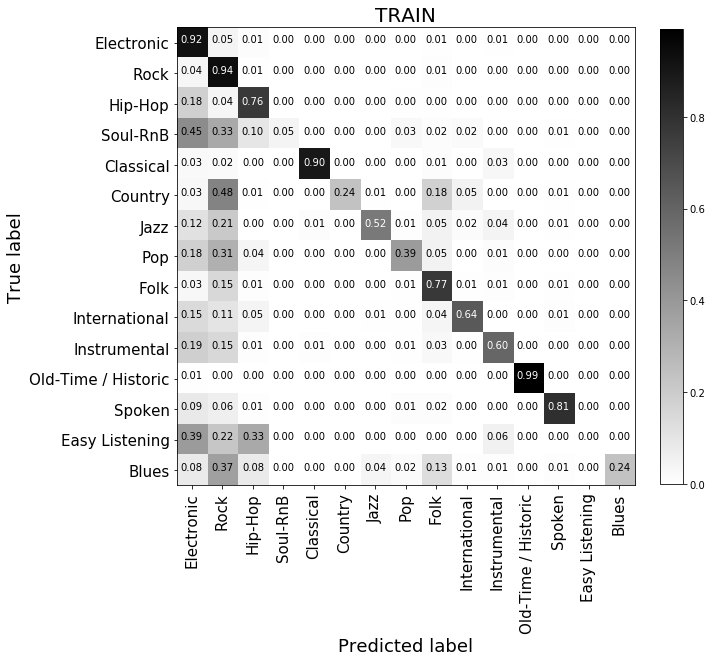


Test Report
Test Accuracy:  0.6779617175375064


C:\Users\defne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                     precision    recall  f1-score   support

              Blues       0.00      0.00      0.00        13
          Classical       0.77      0.85      0.81        87
            Country       0.00      0.00      0.00        18
     Easy Listening       0.00      0.00      0.00         6
         Electronic       0.64      0.85      0.73       839
               Folk       0.39      0.30      0.34       299
            Hip-Hop       0.73      0.70      0.71       323
       Instrumental       0.56      0.21      0.31       309
      International       0.64      0.35      0.45       128
               Jazz       0.80      0.43      0.56        47
Old-Time / Historic       0.91      0.96      0.94        55
                Pop       0.16      0.04      0.06       204
               Rock       0.74      0.89      0.81      1464
           Soul-RnB       0.00      0.00      0.00        43
             Spoken       0.64      0.45      0.53        31

          micro avg   

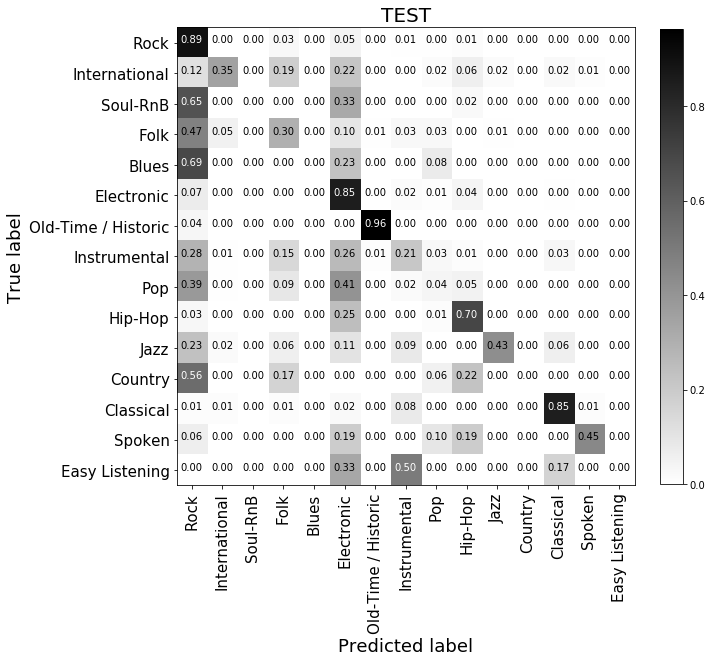

Wall time: 13min 49s


In [6]:
%%time
svm = SVM(tracks, features)
svm.train([MFCC,CONT,CENT])

SVC(C=1.2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Training Report
Train Accuracy:  0.8843597841821292
                     precision    recall  f1-score   support

          Classical       0.97      0.90      0.93      1143
         Electronic       0.84      0.92      0.88      8533
               Folk       0.87      0.78      0.82      2504
            Hip-Hop       0.91      0.76      0.83      3229
       Instrumental       0.86      0.60      0.70      1770
Old-Time / Historic       1.00      0.99      0.99       499
               Rock       0.91      0.94      0.92     12718

          micro avg       0.88      0.88      0.88     30396
          macro avg       0.91      0.84      0.87     30396
       weighted avg       0.89      0.88      0.88     30396



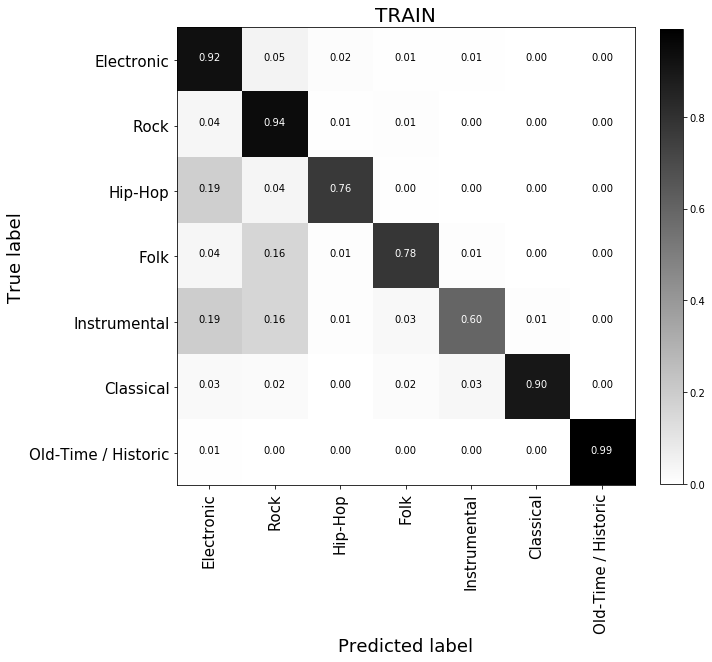


Test Report
Test Accuracy:  0.7582938388625592
                     precision    recall  f1-score   support

          Classical       0.82      0.86      0.84        87
         Electronic       0.73      0.86      0.79       839
               Folk       0.50      0.32      0.39       299
            Hip-Hop       0.80      0.70      0.75       323
       Instrumental       0.61      0.22      0.32       309
Old-Time / Historic       0.90      0.96      0.93        55
               Rock       0.80      0.90      0.85      1464

          micro avg       0.76      0.76      0.76      3376
          macro avg       0.74      0.69      0.70      3376
       weighted avg       0.74      0.76      0.74      3376



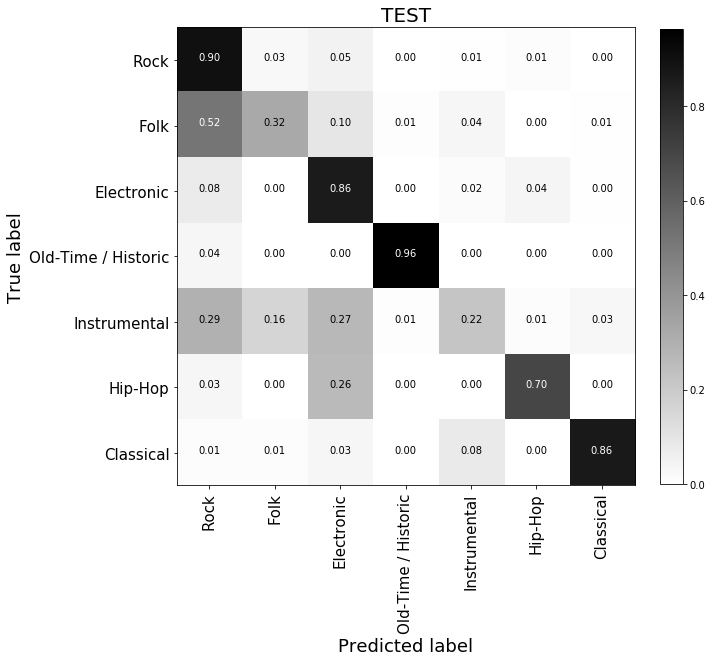

Wall time: 8min 8s


In [7]:
%%time
svm = SVM(tracks, features)
svm.train([MFCC,CONT,CENT],top_eight)

SVC(C=1.2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Training Report
Train Accuracy:  0.9265113374702416
              precision    recall  f1-score   support

   Classical       0.98      0.94      0.96      1143
  Electronic       0.88      0.94      0.91      8533
     Hip-Hop       0.93      0.77      0.84      3229
        Rock       0.95      0.96      0.96     12718

   micro avg       0.93      0.93      0.93     25623
   macro avg       0.94      0.90      0.92     25623
weighted avg       0.93      0.93      0.93     25623



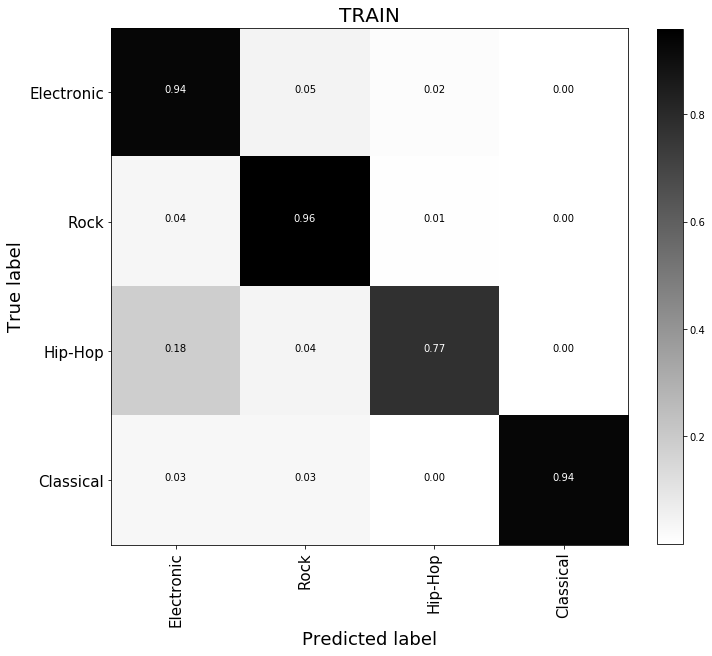


Test Report
Test Accuracy:  0.8820493918171766
              precision    recall  f1-score   support

   Classical       0.92      0.91      0.91        87
  Electronic       0.80      0.87      0.83       839
     Hip-Hop       0.81      0.70      0.75       323
        Rock       0.94      0.93      0.94      1464

   micro avg       0.88      0.88      0.88      2713
   macro avg       0.87      0.85      0.86      2713
weighted avg       0.88      0.88      0.88      2713



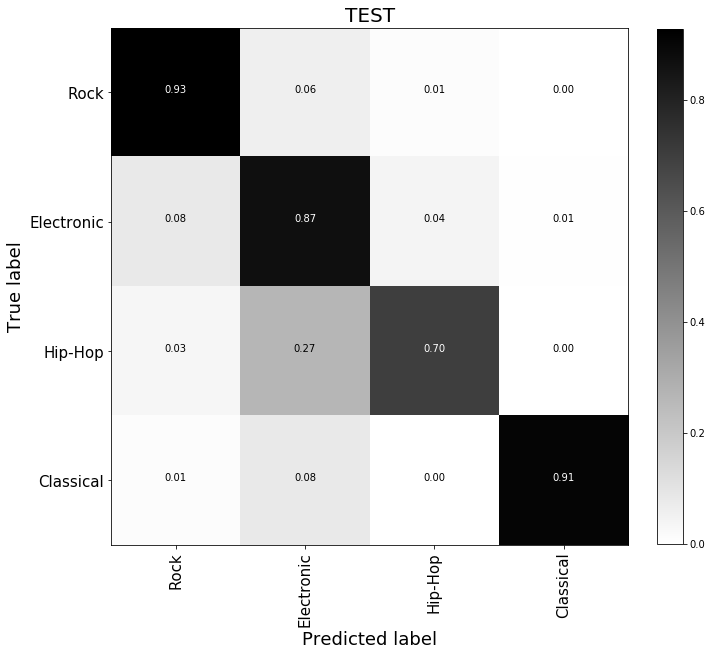

In [8]:
svm = SVM(tracks, features)
svm.train([MFCC,CONT,CENT],top_four)